# Consumo de gas en Punta Arenas (Python)
---

1.- [Explorar datos](#explore)
&nbsp;

2.- [Pre-procesamiento](#pre)
&nbsp;

3.- [Modelar datos](#model)

&nbsp;
    3.1.- [Random Forest](#rf)

&nbsp;
    3.2.- [Support Vector Regression](#svr)
    
&nbsp;
    3.3.- [Decision Trees](#dl)
&nbsp;

4.- [Análisis y evaluación de los modelos](#anal)
&nbsp;

## 1.- Explorar datos
<a id="explore"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

Primero se importa el conjunto de datos y se imprimen los primeros ejemplares para observar su naturaleza.

In [2]:
gasConsume = pd.read_csv('gasConsume.csv', sep=";")
gasConsume.head()

Consumo  Dia  Mes   A�o DiaSemana  Feriado
0      716   20   10  1995   Viernes        0
1      605   21   10  1995    S�bado        1
2      555   22   10  1995   Domingo        1
3      680   23   10  1995     Lunes        0
4      713   24   10  1995    Martes        0

In [3]:
gasConsume.columns = ['Consumo', 'Dia','Mes','Ano','DiaSemana','Feriado']
gasConsume.head(1)

Consumo  Dia  Mes   Ano DiaSemana  Feriado
0      716   20   10  1995   Viernes        0

In [4]:
gasConsume.describe()

Consumo          Dia          Mes          Ano      Feriado
count  2630.000000  2630.000000  2630.000000  2630.000000  2630.000000
mean    725.563118    15.776046     6.653992  1998.888213     0.198099
std     171.770851     8.810094     3.491289     2.079180     0.398643
min     333.000000     1.000000     1.000000  1995.000000     0.000000
25%     579.000000     8.000000     4.000000  1997.000000     0.000000
50%     715.000000    16.000000     7.000000  1999.000000     0.000000
75%     876.000000    23.000000    10.000000  2001.000000     0.000000
max    1222.000000    31.000000    12.000000  2002.000000     1.000000

Se puede observar que los datos corresponden a dias, meses y años, un indicador de feriados y por cada fechala magnitud del consumo de gas en valores contiuos.Luego se realizan visualizaciones para estudiar de forma preliminar el comportamiento de los datos.

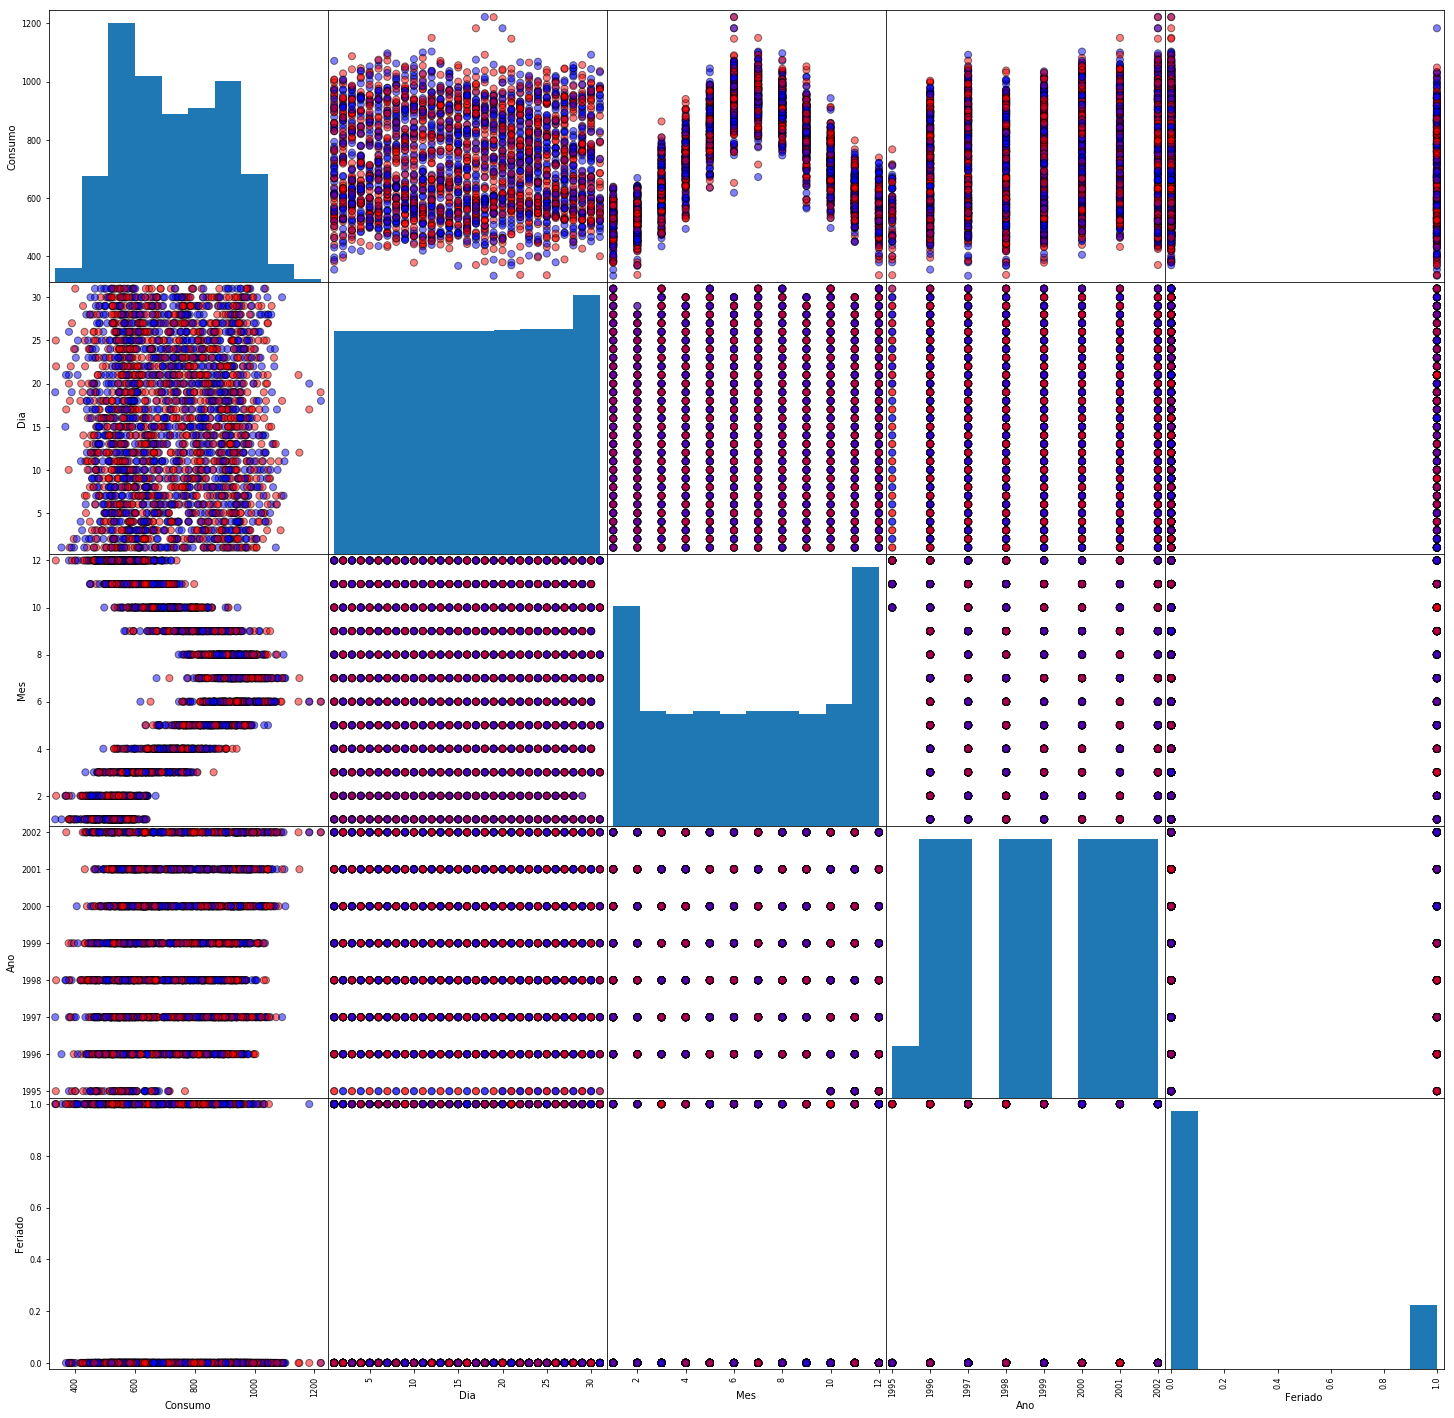

In [5]:
pd.plotting.scatter_matrix(
    gasConsume.loc[0:,gasConsume.columns],c=['red','blue'],alpha=0.5,
    figsize=[25,25],diagonal='hist',s=200,marker='.',edgecolor='black')
plt.show()

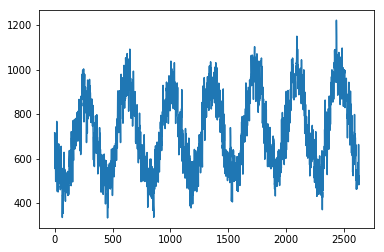

In [6]:
plt.plot(gasConsume["Consumo"])

Se puede apreciar en este gráfico que existe cierto periodo a través de los años en cuanto al consumo de gas.

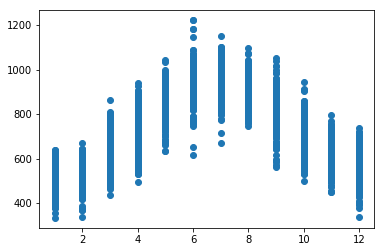

In [16]:
plt.plot(gasConsume["Mes"],gasConsume["Consumo"], 'o')

Los rangos de valores de gas consumido son claramente superiores en algunos meses, aún así van desde las 200
a 400 unidades aproximadamente por lo que sería imposible predecir de esta forma el consumo para un día en específico

Para modelar la forma en que el consumo varía dependiendo basándose en estas variables se debe crear un modelo de regresión. Sin embargo los datos no se encuentran en la forma apropiada para ser modelados de la mejor manera. Por esto se realizara una fase de pre-procesamiento para transformar los datos y obtener los conjuntos de entrenamiento y prueba.

## 2.- Pre-procesamiento
<a id="pre"></a>

Antes de entrenar el modelo es recomendable utilizar el proceso one-hot encoding. Como el conjunto de datos posee valores categórico (los días de semana), lo adecuado es pasarlo a valores numéricos para facilitar el aprendizaje del algoritmo. Una solución podría ser renombrar esta variable con valores del 1 al 7 para  representar los días, pero esto podría conducir a que el algoritmo le de mayor peso al Domingo por ser el  número 7 que al Lunes por ser el 1, por lo tanto es recomendable convertir esta variable en una matriz de datos binarios.

In [7]:
gasConsume = pd.get_dummies(gasConsume)
gasConsume.head()

Consumo  Dia  Mes   Ano  Feriado  DiaSemana_Domingo  DiaSemana_Jueves  \
0      716   20   10  1995        0                  0                 0   
1      605   21   10  1995        1                  0                 0   
2      555   22   10  1995        1                  1                 0   
3      680   23   10  1995        0                  0                 0   
4      713   24   10  1995        0                  0                 0   

   DiaSemana_Lunes  DiaSemana_Martes  DiaSemana_Mi�rcoles  DiaSemana_S�bado  \
0                0                 0                    0                 0   
1                0                 0                    0                 1   
2                0                 0                    0                 0   
3                1                 0                    0                 0   
4                0                 1                    0                 0   

   DiaSemana_Viernes  
0                  1  
1                  0  
2                  0  
3                  0  
4                  0

Se puede apreciar como se crea una columna por cada valor categórico encontrado

Luego es recomendable escalar los datos ya que poseen diversas escalas de magnitudes en las columnas lo que provocará que algunos tengan mayor influencia sobre el modelo. Para esto se crea una pequeña función que dejará a las características en rangos de 0 a 1 (no es necesario hacer eso con la variable que se intenta predecir)

In [8]:
def normalized(x):
    normalData =(x-min(x))/(max(x)-min(x))
    return normalData

In [9]:
gasConsume["Dia"] = normalized(gasConsume["Dia"])
gasConsume["Mes"] = normalized(gasConsume["Mes"])
gasConsume["Ano"] = normalized(gasConsume["Ano"])
gasConsume.head()

Consumo       Dia       Mes  Ano  Feriado  DiaSemana_Domingo  \
0      716  0.633333  0.818182  0.0        0                  0   
1      605  0.666667  0.818182  0.0        1                  0   
2      555  0.700000  0.818182  0.0        1                  1   
3      680  0.733333  0.818182  0.0        0                  0   
4      713  0.766667  0.818182  0.0        0                  0   

   DiaSemana_Jueves  DiaSemana_Lunes  DiaSemana_Martes  DiaSemana_Mi�rcoles  \
0                 0                0                 0                    0   
1                 0                0                 0                    0   
2                 0                0                 0                    0   
3                 0                1                 0                    0   
4                 0                0                 1                    0   

   DiaSemana_S�bado  DiaSemana_Viernes  
0                 0                  1  
1                 1                  0  
2                 0                  0  
3                 0                  0  
4                 0                  0

Se separan los conjuntos de variables predictoras o características (features) y objetivos (labels)

In [10]:
labels = np.array(gasConsume['Consumo'])

In [11]:
features = gasConsume.drop('Consumo', axis = 1)

In [12]:
feature_list = list(features.columns)
features = np.array(features)

Se importa el módulo para obtener los conjuntos de entrenamiento y prueba. Estos se obtienen de forma aleatoria y se utiliza el número de semilla 42 para asegurar la reproducción de las pruebas.

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size = 0.25, random_state = 42)

El conjunto de entrenamiento corresponde al 75% de la muestra. Este tamaño resulta apropiado para que el conjunto de test posea datos suficientes a lo largo de cada mes del año para predecir

In [16]:
train_features = pd.DataFrame(train_features)
test_features = pd.DataFrame(test_features)
train_features.columns = feature_list
test_features.columns = feature_list

In [17]:
train_features.head()

Dia       Mes       Ano  Feriado  DiaSemana_Domingo  DiaSemana_Jueves  \
0  0.133333  0.818182  0.571429      0.0                0.0               0.0   
1  0.466667  0.818182  0.571429      0.0                0.0               0.0   
2  0.733333  0.545455  1.000000      0.0                0.0               0.0   
3  0.000000  0.636364  0.857143      0.0                0.0               0.0   
4  0.100000  0.818182  1.000000      0.0                0.0               0.0   

   DiaSemana_Lunes  DiaSemana_Martes  DiaSemana_Mi�rcoles  DiaSemana_S�bado  \
0              0.0               1.0                  0.0               0.0   
1              0.0               0.0                  0.0               0.0   
2              0.0               1.0                  0.0               0.0   
3              0.0               0.0                  1.0               0.0   
4              0.0               0.0                  0.0               0.0   

   DiaSemana_Viernes  
0                0.0  
1                1.0  
2                0.0  
3                0.0  
4                1.0

In [18]:
import seaborn as sns

Se realizan algunos gráficos de densidad para comprobar que los datos poseen distribuciónes similares

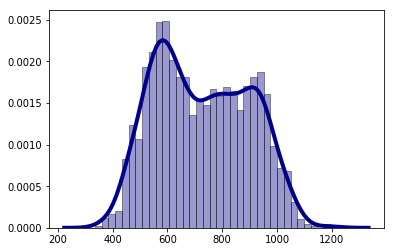

In [19]:
sns.distplot(train_labels, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

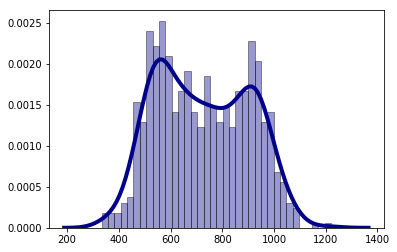

In [20]:
sns.distplot(test_labels, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

Además vale la pena probar que la distribución de los datos no poseen diferencias significativas. En caso de ser datos normales se puede recurrir al test de t-student, de otra forma al de Wilcox-Mann Whitney. Para probar la normalidad se usa el test de Shapiro Wilk. Se aplicarán estos test en los valores de consumo y mes cuya varianza puede resultar más riesgosa para el modelo.

In [21]:
from scipy.stats import mannwhitneyu, shapiro

Comprobar normalidad

In [26]:
shapiro(train_labels)

(0.969205915927887, 3.9373393260740644e-20)

In [24]:
shapiro(test_labels)

(0.9668837785720825, 4.929867972180979e-11)

In [27]:
shapiro(train_features["Mes"])

(0.9370741844177246, 4.060206508675797e-28)

In [28]:
shapiro(test_features["Mes"])

(0.9389985799789429, 8.924006671839511e-16)

Se puede comprobar que todos los p-values son mucho menores a 0.05, el nivel de confianza generalmente aceptado. Por lo tanto ninguno de estos datos corresponde a una distribución normal.

In [29]:
mannwhitneyu(train_labels, test_labels)

MannwhitneyuResult(statistic=643456.0, pvalue=0.37596611371196176)

In [29]:
mannwhitneyu(train_features["Mes"], test_features["Mes"])

MannwhitneyuResult(statistic=636836.5, pvalue=0.23852771749246937)

Como el test de Mann Whitney arroja valores superiores a 0.05 en sus p-values, no se puede afirmar que existe una diferencia significativa en los datos.

## 3.- Modelar datos
<a id="model"></a>

### 3.1.- Random Forest
<a id="rf"></a>

In [31]:
import scipy

In [32]:
from sklearn.ensemble import RandomForestRegressor

Para escoger parámetros apropiados para crear el modelo se utiliza Grid Search, que consta básicamente de probar todas las combinaciones de una tupla de parámetros para encontrar el mejor ajuste. Entro los parámetros importantes a ajustar se encuentran # El numeto de árboles creado (ntree) regula el control del error en el modelo en contraste con el sobreajuste el número de árboles creado (n_estimators), que regula el control del error en el modelo en contraste con el sobreajuste a los datos. También afecta en el tiempo de ejecución el que aumenta a gran escala con un valor muy
grande. maxfeatures es la cantidad de variables que se seleccionan aleatoriamente para cada división.
max_depth controla el tamaño mínimo de los nodos terminales y por lo tanto afecta la profundidad del árbol. min_samples_split es el mínimo de muestras requeridas para dividir un nodo.

In [33]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 300, 500, 1000]
}

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(train_features, train_labels)

Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=2, min_samples_split=8, max_depth=80 
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=2, min_samples_split=8, max_depth=80 
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=2, min_samples_split=8, max_depth=80 
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=2, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=2, min_samples_split=8, max_depth=80, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=2, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=2, min_samples_split=8, max_depth=80, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=2, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min

[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=2, min_samples_split=8, max_depth=80 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.2s


[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=2, min_samples_split=8, max_depth=80, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=2, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=2, min_samples_split=8, max_depth=80, total=   0.8s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=2, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=2, min_samples_split=8, max_depth=80, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=2, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=2, min_samples_split=12, max_depth=80, total=   4.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=2, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=2, min_samples_split=12, max_depth=80, total=   2.0s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=2, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=2, min_samples_split=8, max_depth=80, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=2, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=2, min_samples_split=8, max_depth=80, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=2, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=2, min_samples_split=8, max_depth=80, total=   0.3s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=2, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=2, min_samples_split=12, max_depth=80, total=   1.8s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=2, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=2, min_samples_split=12, max_depth=80, total=   1.8s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=3, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=3, min_samples_split=8, max_depth=80, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=3, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=3, min_samples_split=8, max_depth=80, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=3, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=3, min_samples_split=12, max_depth=80, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=3, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=3, min_samples_split=12, max_depth=80, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=3, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=3, min_samples_split=12, max_depth=80, total=   2.0s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=3, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=3, min_samples_split=8, max_depth=80, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=3, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimator

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min


[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=3, min_samples_split=10, max_depth=80, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=3, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=3, min_samples_split=10, max_depth=80, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=3, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=3, min_samples_split=8, max_depth=80, total=   3.8s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=3, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=3, min_samples_split=10, max_depth=80, total=   1.1s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=3, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimato

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=3, min_samples_split=10, max_depth=80, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=3, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=3, min_samples_split=10, max_depth=80, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=3, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=3, min_samples_split=10, max_depth=80, total=   0.3s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=3, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=3, min_samples_split=8, max_depth=80, total=   4.3s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=3, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimato

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=4, min_samples_split=8, max_depth=80, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=4, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=4, min_samples_split=10, max_depth=80, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=4, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=4, min_samples_split=10, max_depth=80, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=4, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=4, min_samples_split=10, max_depth=80, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=4, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimator

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=4, min_samples_split=8, max_depth=80, total=   1.8s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=4, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=4, min_samples_split=8, max_depth=80, total=   1.8s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=4, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=4, min_samples_split=10, max_depth=80, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=4, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=4, min_samples_split=10, max_depth=80, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=4, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=4, min_samples_split=8, max_depth=80, total=   1.9s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=4, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=4, min_samples_split=8, max_depth=80, total=   1.9s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=4, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=4, min_samples_split=8, max_depth=80, total=   2.0s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=4, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=4, min_samples_split=10, max_depth=80, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=4, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=5, min_samples_split=8, max_depth=80, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=5, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=5, min_samples_split=8, max_depth=80, total=   1.9s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=5, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=5, min_samples_split=8, max_depth=80, total=   1.9s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=5, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=5, min_samples_split=8, max_depth=80, total=   1.9s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=5, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min


[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=5, min_samples_split=8, max_depth=80, total=   0.6s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=5, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=5, min_samples_split=8, max_depth=80, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=5, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=5, min_samples_split=8, max_depth=80, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=5, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=5, min_samples_split=12, max_depth=80, total=   4.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=5, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=5, min_samples_split=12, max_depth=80, total=   2.3s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=5, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=5, min_samples_split=8, max_depth=80, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=5, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=5, min_samples_split=8, max_depth=80, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=5, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=5, min_samples_split=8, max_depth=80, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=5, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=5, min_samples_split=12, max_depth=80, total=   2.0s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=5, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=5, min_samples_split=12, max_depth=80, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=6, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=6, min_samples_split=8, max_depth=80, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=6, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=6, min_samples_split=8, max_depth=80, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=6, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=6, min_samples_split=12, max_depth=80, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=6, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=6, min_samples_split=12, max_depth=80, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=6, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=6, min_samples_split=12, max_depth=80, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=6, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=6, min_samples_split=8, max_depth=80, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=6, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimator

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=6, min_samples_split=10, max_depth=80, total=   4.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=6, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=6, min_samples_split=12, max_depth=80, total=   2.0s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=6, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=6, min_samples_split=12, max_depth=80, total=   2.0s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=6, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=6, min_samples_split=12, max_depth=80, total=   2.0s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=6, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estim

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=6, min_samples_split=10, max_depth=80, total=   4.1s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=6, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=6, min_samples_split=10, max_depth=80, total=   4.1s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=6, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=6, min_samples_split=12, max_depth=80, total=   2.0s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=6, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=6, min_samples_split=12, max_depth=80, total=   2.0s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=6, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_est

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=7, min_samples_split=10, max_depth=80, total=   5.2s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=7, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=7, min_samples_split=12, max_depth=80, total=   1.8s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=7, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=7, min_samples_split=10, max_depth=80, total=   5.3s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=7, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=7, min_samples_split=12, max_depth=80, total=   2.6s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=7, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_esti

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=7, min_samples_split=12, max_depth=80, total=   1.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=7, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=7, min_samples_split=10, max_depth=80, total=   4.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=7, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=7, min_samples_split=12, max_depth=80, total=   1.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=7, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=7, min_samples_split=10, max_depth=80, total=   4.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=7, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estim

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=7, min_samples_split=12, max_depth=80, total=   1.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=7, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=7, min_samples_split=12, max_depth=80, total=   1.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=7, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=7, min_samples_split=12, max_depth=80, total=   1.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=7, min_samples_split=12, max_depth=80 


[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  5.6min


[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=7, min_samples_split=10, max_depth=80, total=   4.6s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=7, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=7, min_samples_split=10, max_depth=80, total=   4.6s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=7, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=7, min_samples_split=12, max_depth=80, total=   2.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=7, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=7, min_samples_split=12, max_depth=80, total=   2.3s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=7, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_est

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=8, min_samples_split=12, max_depth=80, total=   1.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=8, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=8, min_samples_split=10, max_depth=80, total=   4.5s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=8, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=8, min_samples_split=10, max_depth=80, total=   4.6s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=8, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=8, min_samples_split=12, max_depth=80, total=   2.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=8, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_esti

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=8, min_samples_split=12, max_depth=80, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=8, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=8, min_samples_split=10, max_depth=80, total=   4.6s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=8, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=8, min_samples_split=12, max_depth=80, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=8, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=8, min_samples_split=10, max_depth=80, total=   4.6s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=8, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estim

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=8, min_samples_split=12, max_depth=80, total=   1.5s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=8, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=8, min_samples_split=12, max_depth=80, total=   1.6s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=8, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=8, min_samples_split=10, max_depth=80, total=   4.7s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=8, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=8, min_samples_split=10, max_depth=80, total=   4.6s
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=8, min_samples_split=12, max_depth=80, total=   1.4s
[CV] bootstrap=True, min_samples_le

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=9, min_samples_split=10, max_depth=80, total=   5.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=9, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=9, min_samples_split=12, max_depth=80, total=   1.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=9, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=9, min_samples_split=12, max_depth=80, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=9, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=9, min_samples_split=12, max_depth=80, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=9, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimat

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=9, min_samples_split=12, max_depth=80, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=9, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=9, min_samples_split=10, max_depth=80, total=   4.9s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=9, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=9, min_samples_split=12, max_depth=80, total=   1.5s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=9, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=9, min_samples_split=12, max_depth=80, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=9, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimat

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=9, min_samples_split=12, max_depth=80, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=9, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=9, min_samples_split=12, max_depth=80, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=9, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=9, min_samples_split=10, max_depth=80, total=   4.6s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=9, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=9, min_samples_split=12, max_depth=80, total=   1.6s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=9, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimat

[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=10, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=10, min_samples_split=12, max_depth=80, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=10, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=10, min_samples_split=12, max_depth=80, total=   0.6s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=10, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=10, min_samples_split=12, max_depth=80, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=10, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=10, min_samples_split=10, max_depth=80, total=   5.2s
[CV] bootstrap=True, min_samples_leaf=3, n_

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=10, min_samples_split=10, max_depth=80, total=   2.6s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=10, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=10, min_samples_split=10, max_depth=80, total=   2.6s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=10, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=10, min_samples_split=12, max_depth=80, total=   0.6s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=10, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=10, min_samples_split=12, max_depth=80, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=10, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n

[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=10, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=10, min_samples_split=10, max_depth=80, total=   2.6s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=10, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=10, min_samples_split=10, max_depth=80, total=   2.5s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=10, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=10, min_samples_split=10, max_depth=80, total=   2.6s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=10, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=10, min_samples_split=12, max_depth=80, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, 

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=11, min_samples_split=8, max_depth=80, total=   5.0s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=11, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=11, min_samples_split=8, max_depth=80, total=   5.0s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=11, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=11, min_samples_split=10, max_depth=80, total=   2.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=11, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=11, min_samples_split=10, max_depth=80, total=   2.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=11, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3,

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  9.2min


[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=11, min_samples_split=8, max_depth=80, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=11, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=11, min_samples_split=8, max_depth=80, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=11, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=11, min_samples_split=8, max_depth=80, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=11, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=11, min_samples_split=12, max_depth=80, total=   4.9s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=11, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estima

[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=11, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=11, min_samples_split=12, max_depth=80, total=   2.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=11, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=11, min_samples_split=8, max_depth=80, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=11, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=11, min_samples_split=8, max_depth=80, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=11, min_samples_split=8, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=11, min_samples_split=8, max_depth=80, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=5, n_estima

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=11, min_samples_split=12, max_depth=80, total=   2.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=11, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=11, min_samples_split=12, max_depth=80, total=   2.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=11, min_samples_split=12, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=11, min_samples_split=12, max_depth=80, total=   2.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=2, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=2, min_samples_split=8, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=2, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_esti

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=2, min_samples_split=10, max_depth=90, total=   3.8s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=2, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=2, min_samples_split=12, max_depth=90, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=2, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=2, min_samples_split=12, max_depth=90, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=2, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=2, min_samples_split=12, max_depth=90, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=2, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estim

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=2, min_samples_split=10, max_depth=90, total=   4.0s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=2, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=2, min_samples_split=10, max_depth=90, total=   3.9s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=2, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=2, min_samples_split=12, max_depth=90, total=   1.9s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=2, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=2, min_samples_split=12, max_depth=90, total=   1.9s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=2, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_est

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=2, min_samples_split=12, max_depth=90, total=   1.1s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=2, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=2, min_samples_split=10, max_depth=90, total=   3.6s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=2, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=2, min_samples_split=10, max_depth=90, total=   3.6s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=2, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=2, min_samples_split=12, max_depth=90, total=   1.8s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=2, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_esti

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=3, min_samples_split=12, max_depth=90, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=3, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=3, min_samples_split=12, max_depth=90, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=3, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=3, min_samples_split=10, max_depth=90, total=   4.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=3, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=3, min_samples_split=10, max_depth=90, total=   4.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=3, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estim

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=3, min_samples_split=12, max_depth=90, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=3, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=3, min_samples_split=12, max_depth=90, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=3, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=3, min_samples_split=12, max_depth=90, total=   1.2s
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=3, min_samples_split=10, max_depth=90, total=   3.9s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=3, min_samples_split=12, max_depth=90 
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=3, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimat

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=3, min_samples_split=10, max_depth=90, total=   3.6s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=3, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=3, min_samples_split=12, max_depth=90, total=   1.1s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=3, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=3, min_samples_split=12, max_depth=90, total=   1.1s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=3, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=3, min_samples_split=12, max_depth=90, total=   1.1s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=3, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimat

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=4, min_samples_split=12, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=4, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=4, min_samples_split=10, max_depth=90, total=   4.0s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=4, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=4, min_samples_split=12, max_depth=90, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=4, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=4, min_samples_split=12, max_depth=90, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=4, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimat

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=4, min_samples_split=12, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=4, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=4, min_samples_split=12, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=4, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=4, min_samples_split=10, max_depth=90, total=   3.8s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=4, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=4, min_samples_split=12, max_depth=90, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=4, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimat

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=4, min_samples_split=12, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=4, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=4, min_samples_split=12, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=4, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=4, min_samples_split=12, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=4, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=4, min_samples_split=10, max_depth=90, total=   3.8s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=4, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimat

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=5, min_samples_split=10, max_depth=90, total=   2.0s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=5, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=5, min_samples_split=12, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=5, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=5, min_samples_split=12, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=5, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=5, min_samples_split=12, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=5, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimato

[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 13.0min


[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=5, min_samples_split=10, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=5, min_samples_split=10, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=5, min_samples_split=10, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=5, min_samples_split=10, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=5, min_samples_split=8, max_depth=90, total=   4.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=5, min_samples_split=10, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=5, min_samples_split=10, max_depth=90, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=5, min_samples_split=10, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimato

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=5, min_samples_split=10, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=5, min_samples_split=10, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=5, min_samples_split=10, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=5, min_samples_split=10, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=5, min_samples_split=10, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=5, min_samples_split=10, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=5, min_samples_split=8, max_depth=90, total=   4.1s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=5, min_samples_split=10, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimato

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=6, min_samples_split=8, max_depth=90, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=6, min_samples_split=10, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=6, min_samples_split=10, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=6, min_samples_split=10, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=6, min_samples_split=10, max_depth=90, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=6, min_samples_split=10, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=6, min_samples_split=10, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=6, min_samples_split=10, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimator

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=6, min_samples_split=8, max_depth=90, total=   2.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=6, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=6, min_samples_split=8, max_depth=90, total=   2.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=6, min_samples_split=10, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=6, min_samples_split=10, max_depth=90, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=6, min_samples_split=10, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=6, min_samples_split=10, max_depth=90, total=   0.6s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=6, min_samples_split=10, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=6, min_samples_split=8, max_depth=90, total=   2.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=6, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=6, min_samples_split=8, max_depth=90, total=   2.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=6, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=6, min_samples_split=8, max_depth=90, total=   2.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=6, min_samples_split=10, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=6, min_samples_split=10, max_depth=90, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=6, min_samples_split=10, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=6, min_samples_split=12, max_depth=90, total=   4.8s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=7, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=7, min_samples_split=8, max_depth=90, total=   2.5s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=7, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=7, min_samples_split=8, max_depth=90, total=   2.5s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=7, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=7, min_samples_split=8, max_depth=90, total=   2.5s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=7, min_samples_split=10, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=7, min_samples_split=12, max_depth=90, total=   4.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=7, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=7, min_samples_split=12, max_depth=90, total=   4.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=7, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=7, min_samples_split=8, max_depth=90, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=7, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=7, min_samples_split=8, max_depth=90, total=   2.2s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=7, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimator

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=7, min_samples_split=8, max_depth=90, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=7, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=7, min_samples_split=12, max_depth=90, total=   4.2s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=7, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=7, min_samples_split=12, max_depth=90, total=   4.2s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=7, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=7, min_samples_split=8, max_depth=90, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=7, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=8, min_samples_split=8, max_depth=90, total=   1.5s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=8, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=7, min_samples_split=12, max_depth=90, total=   5.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=8, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=8, min_samples_split=8, max_depth=90, total=   1.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=8, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=7, min_samples_split=12, max_depth=90, total=   5.2s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=8, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=8, min_samples_split=8, max_depth=90, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=8, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=8, min_samples_split=8, max_depth=90, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=8, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=8, min_samples_split=8, max_depth=90, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=8, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=8, min_samples_split=12, max_depth=90, total=   4.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=8, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=8, min_samples_split=12, max_depth=90, total=   4.1s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=8, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=8, min_samples_split=8, max_depth=90, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=8, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=8, min_samples_split=8, max_depth=90, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=8, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=8, min_samples_split=8, max_depth=90, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=8, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=9, min_samples_split=8, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=9, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=8, min_samples_split=12, max_depth=90, total=   4.2s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=9, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=9, min_samples_split=8, max_depth=90, total=   1.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=9, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=9, min_samples_split=8, max_depth=90, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=9, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=9, min_samples_split=8, max_depth=90, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=9, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=9, min_samples_split=8, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=9, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=9, min_samples_split=12, max_depth=90, total=   4.5s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=9, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=9, min_samples_split=8, max_depth=90, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=9, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=9, min_samples_split=8, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=9, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=9, min_samples_split=8, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=9, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=9, min_samples_split=8, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=9, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=9, min_samples_split=12, max_depth=90, total=   4.3s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=9, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=9, min_samples_split=12, max_depth=90, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=10, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=10, min_samples_split=8, max_depth=90, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=10, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=10, min_samples_split=8, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=10, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=10, min_samples_split=8, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=10, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimato

[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=10, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=10, min_samples_split=12, max_depth=90, total=   2.2s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=10, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=10, min_samples_split=12, max_depth=90, total=   2.2s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=10, min_samples_split=8, max_depth=90 


[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 17.8min


[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=10, min_samples_split=8, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=10, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=10, min_samples_split=8, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=10, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=10, min_samples_split=8, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=10, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=10, min_samples_split=12, max_depth=90, total=   4.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=10, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estima

[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=10, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=10, min_samples_split=12, max_depth=90, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=10, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=10, min_samples_split=8, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=10, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=10, min_samples_split=8, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=10, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=10, min_samples_split=8, max_depth=90, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estima

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=10, min_samples_split=12, max_depth=90, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=10, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=10, min_samples_split=12, max_depth=90, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=10, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=10, min_samples_split=12, max_depth=90, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=11, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=11, min_samples_split=8, max_depth=90, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=11, min_samples_split=8, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_e

[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=11, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=11, min_samples_split=10, max_depth=90, total=   4.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=11, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=11, min_samples_split=12, max_depth=90, total=   2.2s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=11, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=11, min_samples_split=12, max_depth=90, total=   2.2s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=11, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=11, min_samples_split=12, max_depth=90, total=   2.2s
[CV] bootstrap=True, min_samples_leaf=4,

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=11, min_samples_split=12, max_depth=90, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=11, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=11, min_samples_split=10, max_depth=90, total=   4.5s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=11, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=11, min_samples_split=10, max_depth=90, total=   4.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=11, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=11, min_samples_split=12, max_depth=90, total=   2.2s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=11, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=4

[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=11, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=11, min_samples_split=12, max_depth=90, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=11, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=11, min_samples_split=12, max_depth=90, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=11, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=11, min_samples_split=10, max_depth=90, total=   4.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=11, min_samples_split=12, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=11, min_samples_split=10, max_depth=90, total=   4.4s
[CV] bootstrap=True, min_samples_leaf=5, n

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=2, min_samples_split=10, max_depth=100, total=   3.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=2, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=2, min_samples_split=12, max_depth=100, total=   1.0s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=2, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=2, min_samples_split=12, max_depth=100, total=   1.0s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=2, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=2, min_samples_split=10, max_depth=100, total=   3.5s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=2, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, 

[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=2, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=2, min_samples_split=12, max_depth=100, total=   0.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=2, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=2, min_samples_split=10, max_depth=100, total=   3.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=2, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=2, min_samples_split=12, max_depth=100, total=   1.0s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=2, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=2, min_samples_split=12, max_depth=100, total=   1.1s
[CV] bootstrap=True, min_samples_leaf=4, n_

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=2, min_samples_split=12, max_depth=100, total=   0.3s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=2, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=2, min_samples_split=12, max_depth=100, total=   0.3s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=2, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=2, min_samples_split=12, max_depth=100, total=   0.3s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=2, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=2, min_samples_split=10, max_depth=100, total=   3.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=2, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n

[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=3, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=3, min_samples_split=10, max_depth=100, total=   1.8s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=3, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=3, min_samples_split=12, max_depth=100, total=   0.3s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=3, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=3, min_samples_split=12, max_depth=100, total=   0.3s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=3, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=3, min_samples_split=12, max_depth=100, total=   0.3s
[CV] bootstrap=True, min_samples_leaf=3, n_

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=3, min_samples_split=10, max_depth=100, total=   1.7s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=3, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=3, min_samples_split=10, max_depth=100, total=   1.7s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=3, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=3, min_samples_split=10, max_depth=100, total=   1.8s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=3, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=3, min_samples_split=12, max_depth=100, total=   0.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=3, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, 

[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=3, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=3, min_samples_split=8, max_depth=100, total=   3.5s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=3, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=3, min_samples_split=10, max_depth=100, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=3, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=3, min_samples_split=10, max_depth=100, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=3, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=3, min_samples_split=10, max_depth=100, total=   2.2s
[CV] bootstrap=True, min_samples_leaf=5, 

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=4, min_samples_split=10, max_depth=100, total=   1.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=4, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=4, min_samples_split=8, max_depth=100, total=   3.8s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=4, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=4, min_samples_split=8, max_depth=100, total=   3.7s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=4, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=4, min_samples_split=10, max_depth=100, total=   1.9s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=4, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, 

[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=4, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=4, min_samples_split=10, max_depth=100, total=   1.1s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=4, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=4, min_samples_split=10, max_depth=100, total=   1.1s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=4, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=4, min_samples_split=8, max_depth=100, total=   3.8s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=4, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=4, min_samples_split=8, max_depth=100, total=   3.8s
[CV] bootstrap=True, min_samples_leaf=4, n_e

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=4, min_samples_split=8, max_depth=100, total=   3.6s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=4, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=4, min_samples_split=10, max_depth=100, total=   1.1s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=4, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=4, min_samples_split=10, max_depth=100, total=   1.1s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=4, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=4, min_samples_split=8, max_depth=100, total=   3.6s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=4, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_

[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=5, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=5, min_samples_split=10, max_depth=100, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=5, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=5, min_samples_split=8, max_depth=100, total=   4.0s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=5, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=5, min_samples_split=10, max_depth=100, total=   1.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=5, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=5, min_samples_split=10, max_depth=100, total=   1.1s
[CV] bootstrap=True, min_samples_leaf=3, n_e

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=5, min_samples_split=10, max_depth=100, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=5, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=5, min_samples_split=10, max_depth=100, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=5, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=5, min_samples_split=10, max_depth=100, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=5, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=5, min_samples_split=8, max_depth=100, total=   4.8s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=5, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_

[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=5, min_samples_split=8, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=5, min_samples_split=8, max_depth=100, total=   2.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=5, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=5, min_samples_split=10, max_depth=100, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=5, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=5, min_samples_split=10, max_depth=100, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=5, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=5, min_samples_split=10, max_depth=100, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_es

[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 48.1min


[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=5, min_samples_split=10, max_depth=100, total=   3.9s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=5, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=5, min_samples_split=12, max_depth=100, total=   1.8s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=5, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=5, min_samples_split=12, max_depth=100, total=   1.9s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=5, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=5, min_samples_split=12, max_depth=100, total=   2.0s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=6, min_samples_split=8, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3,

[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=6, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=6, min_samples_split=10, max_depth=100, total=   4.0s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=6, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=6, min_samples_split=10, max_depth=100, total=   4.0s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=6, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=6, min_samples_split=12, max_depth=100, total=   1.9s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=6, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=6, min_samples_split=12, max_depth=100, total=   1.9s
[CV] bootstrap=True, min_samples_leaf=3,

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=6, min_samples_split=12, max_depth=100, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=6, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=6, min_samples_split=12, max_depth=100, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=6, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=6, min_samples_split=10, max_depth=100, total=   3.9s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=6, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=6, min_samples_split=10, max_depth=100, total=   3.9s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=6, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4,

[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=6, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=6, min_samples_split=12, max_depth=100, total=   1.1s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=6, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=6, min_samples_split=12, max_depth=100, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=6, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=6, min_samples_split=12, max_depth=100, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=6, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=6, min_samples_split=10, max_depth=100, total=   3.9s
[CV] bootstrap=True, min_samples_leaf=5, n_

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=7, min_samples_split=12, max_depth=100, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=7, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=7, min_samples_split=10, max_depth=100, total=   4.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=7, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=7, min_samples_split=12, max_depth=100, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=7, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=7, min_samples_split=12, max_depth=100, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=7, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n

[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=7, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=7, min_samples_split=12, max_depth=100, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=7, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=7, min_samples_split=12, max_depth=100, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=7, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=7, min_samples_split=10, max_depth=100, total=   4.0s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=7, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=7, min_samples_split=12, max_depth=100, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=4, n_

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=7, min_samples_split=10, max_depth=100, total=   2.0s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=7, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=7, min_samples_split=12, max_depth=100, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=7, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=7, min_samples_split=12, max_depth=100, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=7, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=7, min_samples_split=12, max_depth=100, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=7, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_

[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=8, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=8, min_samples_split=10, max_depth=100, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=8, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=8, min_samples_split=10, max_depth=100, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=8, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=8, min_samples_split=12, max_depth=100, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=8, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=8, min_samples_split=12, max_depth=100, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=8, min_samples_split=8, max_depth=100, total=   4.1s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=8, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=8, min_samples_split=10, max_depth=100, total=   2.0s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=8, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=8, min_samples_split=10, max_depth=100, total=   2.0s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=8, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=8, min_samples_split=10, max_depth=100, total=   2.0s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=8, min_samples_split=12, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4,

[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=8, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=8, min_samples_split=8, max_depth=100, total=   4.0s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=8, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=8, min_samples_split=8, max_depth=100, total=   4.0s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=8, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=8, min_samples_split=10, max_depth=100, total=   2.0s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=8, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=8, min_samples_split=10, max_depth=100, total=   2.0s
[CV] bootstrap=True, min_samples_leaf=5, n

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=9, min_samples_split=10, max_depth=100, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=9, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=9, min_samples_split=10, max_depth=100, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=9, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=9, min_samples_split=8, max_depth=100, total=   4.3s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=9, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=9, min_samples_split=8, max_depth=100, total=   4.3s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=9, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n

[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=9, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=9, min_samples_split=10, max_depth=100, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=9, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=9, min_samples_split=10, max_depth=100, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=9, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=9, min_samples_split=10, max_depth=100, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=9, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=9, min_samples_split=8, max_depth=100, total=   4.3s
[CV] bootstrap=True, min_samples_leaf=4, n_e

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=9, min_samples_split=10, max_depth=100, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=9, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=9, min_samples_split=8, max_depth=100, total=   4.3s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=9, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=9, min_samples_split=10, max_depth=100, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=9, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=9, min_samples_split=10, max_depth=100, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=9, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_

[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=10, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=10, min_samples_split=10, max_depth=100, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=10, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=10, min_samples_split=10, max_depth=100, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=10, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=10, min_samples_split=8, max_depth=100, total=   4.7s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=10, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=10, min_samples_split=10, max_depth=100, total=   1.3s
[CV] bootstrap=True, min_samples_lea

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=10, min_samples_split=8, max_depth=100, total=   2.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=10, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=10, min_samples_split=10, max_depth=100, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=10, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=10, min_samples_split=10, max_depth=100, total=   0.5s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=10, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=10, min_samples_split=10, max_depth=100, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=10, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_lea

[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=10, min_samples_split=8, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=10, min_samples_split=8, max_depth=100, total=   2.2s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=10, min_samples_split=8, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=10, min_samples_split=8, max_depth=100, total=   2.2s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=10, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=10, min_samples_split=10, max_depth=100, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=10, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=10, min_samples_split=10, max_depth=100, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=11, min_samples_split=8, max_depth=100, total=   1.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=11, min_samples_split=8, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=11, min_samples_split=8, max_depth=100, total=   2.3s
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=11, min_samples_split=8, max_depth=100, total=   2.3s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=11, min_samples_split=8, max_depth=100 
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=11, min_samples_split=8, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=11, min_samples_split=8, max_depth=100, total=   2.3s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=11, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3

[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=11, min_samples_split=8, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=11, min_samples_split=8, max_depth=100, total=   1.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=11, min_samples_split=8, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=11, min_samples_split=12, max_depth=100, total=   4.5s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=11, min_samples_split=8, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=11, min_samples_split=8, max_depth=100, total=   2.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=11, min_samples_split=8, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=11, min_samples_split=8, max_depth=100, total=   2.2s
[CV] bootstrap=True, min_samples_leaf=4,

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=11, min_samples_split=8, max_depth=100, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=11, min_samples_split=8, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=11, min_samples_split=12, max_depth=100, total=   4.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=11, min_samples_split=8, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=11, min_samples_split=8, max_depth=100, total=   1.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=11, min_samples_split=8, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=11, min_samples_split=12, max_depth=100, total=   4.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=11, min_samples_split=8, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=

[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=2, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=11, min_samples_split=12, max_depth=100, total=   4.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=2, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=2, min_samples_split=8, max_depth=110, total=   1.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=2, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=2, min_samples_split=8, max_depth=110, total=   1.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=2, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=11, min_samples_split=12, max_depth=100, total=   4.4s
[CV] bootstrap=True, min_samples_leaf=3, n_est

[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 54.7min


[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=2, min_samples_split=8, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=2, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=2, min_samples_split=8, max_depth=110, total=   0.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=2, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=2, min_samples_split=8, max_depth=110, total=   0.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=2, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=2, min_samples_split=12, max_depth=110, total=   3.5s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=2, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estima

[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=2, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=2, min_samples_split=12, max_depth=110, total=   1.7s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=2, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=2, min_samples_split=8, max_depth=110, total=   0.3s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=2, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=2, min_samples_split=8, max_depth=110, total=   0.3s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=2, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=2, min_samples_split=8, max_depth=110, total=   0.3s
[CV] bootstrap=True, min_samples_leaf=5, n_estima

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=2, min_samples_split=12, max_depth=110, total=   1.7s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=2, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=2, min_samples_split=12, max_depth=110, total=   1.7s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=2, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=2, min_samples_split=12, max_depth=110, total=   1.7s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=3, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=3, min_samples_split=8, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=3, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_e

[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=3, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=3, min_samples_split=10, max_depth=110, total=   3.6s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=3, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=3, min_samples_split=12, max_depth=110, total=   1.8s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=3, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=3, min_samples_split=12, max_depth=110, total=   1.7s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=3, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=3, min_samples_split=12, max_depth=110, total=   1.8s
[CV] bootstrap=True, min_samples_leaf=4,

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=3, min_samples_split=12, max_depth=110, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=3, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=3, min_samples_split=10, max_depth=110, total=   3.8s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=3, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=3, min_samples_split=10, max_depth=110, total=   3.8s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=3, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=3, min_samples_split=12, max_depth=110, total=   1.8s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=3, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4

[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=3, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=3, min_samples_split=12, max_depth=110, total=   1.1s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=3, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=3, min_samples_split=10, max_depth=110, total=   3.5s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=3, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=3, min_samples_split=12, max_depth=110, total=   1.1s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=3, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=3, min_samples_split=10, max_depth=110, total=   3.6s
[CV] bootstrap=True, min_samples_leaf=5, n

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=4, min_samples_split=10, max_depth=110, total=   3.7s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=4, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=4, min_samples_split=12, max_depth=110, total=   1.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=4, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=4, min_samples_split=12, max_depth=110, total=   1.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=4, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=4, min_samples_split=10, max_depth=110, total=   3.7s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=4, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, 

[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=4, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=4, min_samples_split=12, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=4, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=4, min_samples_split=10, max_depth=110, total=   3.7s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=4, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=4, min_samples_split=12, max_depth=110, total=   1.1s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=4, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=4, min_samples_split=10, max_depth=110, total=   3.7s
[CV] bootstrap=True, min_samples_leaf=4, n

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=4, min_samples_split=12, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=4, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=4, min_samples_split=12, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=4, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=4, min_samples_split=12, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=4, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=4, min_samples_split=10, max_depth=110, total=   3.6s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=4, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n

[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=5, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=5, min_samples_split=10, max_depth=110, total=   1.9s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=5, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=5, min_samples_split=12, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=5, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=5, min_samples_split=12, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=5, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=5, min_samples_split=12, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=5, min_samples_split=10, max_depth=110, total=   1.9s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=5, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=5, min_samples_split=10, max_depth=110, total=   1.9s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=5, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=5, min_samples_split=10, max_depth=110, total=   1.9s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=5, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=5, min_samples_split=12, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=5, min_samples_split=12, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, 

[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=5, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=5, min_samples_split=8, max_depth=110, total=   3.8s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=5, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=5, min_samples_split=10, max_depth=110, total=   1.8s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=5, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=5, min_samples_split=10, max_depth=110, total=   1.8s
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=5, min_samples_split=10, max_depth=110, total=   1.9s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=5, min_samples_split=10, max_depth=110 
[CV] bootstrap=True, min_samples_leaf=5, 

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=6, min_samples_split=10, max_depth=110, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=6, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=6, min_samples_split=8, max_depth=110, total=   4.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=6, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=6, min_samples_split=8, max_depth=110, total=   4.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=6, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=6, min_samples_split=10, max_depth=110, total=   2.0s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=6, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, 

[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=6, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=6, min_samples_split=10, max_depth=110, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=6, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=6, min_samples_split=10, max_depth=110, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=6, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=6, min_samples_split=8, max_depth=110, total=   4.0s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=6, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=6, min_samples_split=8, max_depth=110, total=   3.9s
[CV] bootstrap=True, min_samples_leaf=4, n_e

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=6, min_samples_split=8, max_depth=110, total=   3.9s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=6, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=6, min_samples_split=10, max_depth=110, total=   1.1s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=6, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=6, min_samples_split=10, max_depth=110, total=   1.1s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=6, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=6, min_samples_split=10, max_depth=110, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=6, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_

[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=7, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=7, min_samples_split=10, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=7, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=7, min_samples_split=8, max_depth=110, total=   4.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=7, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=7, min_samples_split=10, max_depth=110, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=7, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=7, min_samples_split=10, max_depth=110, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=3, n_e

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=7, min_samples_split=10, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=7, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=7, min_samples_split=10, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=7, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=7, min_samples_split=10, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=7, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=7, min_samples_split=8, max_depth=110, total=   4.1s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=7, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_

[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=7, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=7, min_samples_split=8, max_depth=110, total=   2.0s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=7, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=7, min_samples_split=10, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=7, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=7, min_samples_split=10, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=7, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=7, min_samples_split=10, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_es

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=8, min_samples_split=8, max_depth=110, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=8, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=8, min_samples_split=8, max_depth=110, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=8, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=8, min_samples_split=8, max_depth=110, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=8, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=8, min_samples_split=10, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=8, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_est

[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=8, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=8, min_samples_split=12, max_depth=110, total=   4.2s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=8, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=8, min_samples_split=8, max_depth=110, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=8, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=8, min_samples_split=8, max_depth=110, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=8, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=8, min_samples_split=8, max_depth=110, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=4, n_esti

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=8, min_samples_split=8, max_depth=110, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=8, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=8, min_samples_split=12, max_depth=110, total=   4.1s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=8, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=8, min_samples_split=12, max_depth=110, total=   4.2s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=8, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=8, min_samples_split=8, max_depth=110, total=   2.0s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=8, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_es

[CV] bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=9, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=9, min_samples_split=8, max_depth=110, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=9, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=8, min_samples_split=12, max_depth=110, total=   4.1s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=9, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=8, min_samples_split=12, max_depth=110, total=   4.0s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=9, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=9, min_samples_split=8, max_depth=110, total=   1.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estim

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=9, min_samples_split=12, max_depth=110, total=   4.2s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=9, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=9, min_samples_split=8, max_depth=110, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=9, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=9, min_samples_split=8, max_depth=110, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=9, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=9, min_samples_split=8, max_depth=110, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=9, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estima

[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 60.8min


[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=9, min_samples_split=10, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=9, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=9, min_samples_split=10, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=9, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=9, min_samples_split=8, max_depth=110, total=   4.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=9, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=9, min_samples_split=10, max_depth=110, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=9, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_

[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=9, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=9, min_samples_split=10, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=9, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=9, min_samples_split=10, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=9, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=9, min_samples_split=10, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=9, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=9, min_samples_split=8, max_depth=110, total=   4.2s
[CV] bootstrap=True, min_samples_leaf=5, n_e

[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=10, min_samples_split=8, max_depth=110, total=   2.2s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=10, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=10, min_samples_split=8, max_depth=110, total=   2.2s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=10, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=10, min_samples_split=10, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=10, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=10, min_samples_split=10, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=10, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf

[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=10, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=10, min_samples_split=8, max_depth=110, total=   2.2s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=10, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=10, min_samples_split=8, max_depth=110, total=   2.2s
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=10, min_samples_split=8, max_depth=110, total=   2.2s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=10, min_samples_split=8, max_depth=110 
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=10, min_samples_split=10, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=100, max_features=10, min_samples_split=10, max_depth=110, total=   0.4s
[CV] bootstrap=True, min_samples_leaf=4

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=10, min_samples_split=12, max_depth=110, total=   4.3s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=10, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=10, min_samples_split=12, max_depth=110, total=   4.3s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=10, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=10, min_samples_split=8, max_depth=110, total=   2.2s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=10, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=10, min_samples_split=8, max_depth=110, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=10, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_lea

[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=11, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=10, min_samples_split=12, max_depth=110, total=   4.6s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=11, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=10, min_samples_split=12, max_depth=110, total=   4.6s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=11, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=300, max_features=11, min_samples_split=8, max_depth=110, total=   1.4s
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=11, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=500, max_features=11, min_samples_split=8, max_depth=110, total=   2.4s
[CV] bootstrap=True, min_samples_leaf=3

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=11, min_samples_split=8, max_depth=110, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=11, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=11, min_samples_split=8, max_depth=110, total=   1.4s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=11, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=300, max_features=11, min_samples_split=8, max_depth=110, total=   1.5s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=11, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, n_estimators=1000, max_features=11, min_samples_split=12, max_depth=110, total=   4.5s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=500, max_features=11, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=3, 

[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=11, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1000, max_features=11, min_samples_split=12, max_depth=110, total=   4.4s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=11, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=11, min_samples_split=8, max_depth=110, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=11, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=11, min_samples_split=8, max_depth=110, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=5, n_estimators=500, max_features=11, min_samples_split=8, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=300, max_features=11, min_samples_split=8, max_depth=110, total=   1.3s
[CV] bootstrap=True, min_samples_leaf=5, n

[CV]  bootstrap=True, min_samples_leaf=5, n_estimators=1000, max_features=11, min_samples_split=12, max_depth=110, total=   3.3s


[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed: 63.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'min_samples_leaf': [3, 4, 5], 'n_estimators': [100, 300, 500, 1000], 'min_samples_split': [8, 10, 12], 'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'max_depth': [80, 90, 100, 110]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [36]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 9,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 500}

Luego se entrena el modelo con los mejores parámetros seleccionados. Cabe destacar que se podría seguir buscando parámetros observando la grilla de los mejores resultados y realizando este procedimiento de forma iterativa. 

In [39]:
rfModel = RandomForestRegressor(n_estimators = 1000, bootstrap = True, max_depth = 100, min_samples_leaf = 3,
                           min_samples_split = 8, random_state = 42)

In [40]:
rfModel.fit(train_features, train_labels);

Se obtienen las predicciones correspondientes al conjunto de prueba

In [41]:
rfPredictions = rfModel.predict(test_features)
errors = abs(rfPredictions - test_labels)

MAE es sólo un tipo de error que se puede calcular para comparar los modelos. En la sección final se realiza un análisis más completo.

In [42]:
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

('Mean Absolute Error:', 42.89, 'degrees.')


In [43]:
from sklearn.metrics import mean_squared_error

In [46]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

Para obtener una respuesta más visual, se ordenan los elementos del conjunto de test de acuerdo a su fecha al igual que el conjunto de predicciones. De esta forma será posible visualizar si las prediccion es se ajustan a la curva de los datos reales

In [47]:
order_features = pd.DataFrame(test_features)
order_features.head()

0         1         2    3    4    5    6    7    8    9    10
0  0.900000  0.363636  0.142857  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
1  0.033333  0.727273  0.142857  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
2  0.066667  0.363636  0.428571  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
3  0.433333  0.636364  1.000000  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
4  0.266667  0.727273  0.571429  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0

In [48]:
order_features.columns = feature_list
order_features.head()

Dia       Mes       Ano  Feriado  DiaSemana_Domingo  DiaSemana_Jueves  \
0  0.900000  0.363636  0.142857      0.0                0.0               0.0   
1  0.033333  0.727273  0.142857      0.0                0.0               0.0   
2  0.066667  0.363636  0.428571      1.0                1.0               0.0   
3  0.433333  0.636364  1.000000      0.0                0.0               0.0   
4  0.266667  0.727273  0.571429      0.0                0.0               1.0   

   DiaSemana_Lunes  DiaSemana_Martes  DiaSemana_Mi�rcoles  DiaSemana_S�bado  \
0              0.0               1.0                  0.0               0.0   
1              1.0               0.0                  0.0               0.0   
2              0.0               0.0                  0.0               0.0   
3              0.0               0.0                  1.0               0.0   
4              0.0               0.0                  0.0               0.0   

   DiaSemana_Viernes  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0

In [49]:
order_features.sort_values(['Ano','Mes','Dia'], inplace=True)
order_features.head()

Dia       Mes  Ano  Feriado  DiaSemana_Domingo  DiaSemana_Jueves  \
629  0.200000  0.909091  0.0      0.0                0.0               0.0   
544  0.433333  0.909091  0.0      0.0                0.0               0.0   
433  0.566667  0.909091  0.0      0.0                0.0               0.0   
337  0.600000  0.909091  0.0      1.0                1.0               0.0   
7    0.666667  0.909091  0.0      0.0                0.0               0.0   

     DiaSemana_Lunes  DiaSemana_Martes  DiaSemana_Mi�rcoles  DiaSemana_S�bado  \
629              0.0               1.0                  0.0               0.0   
544              0.0               1.0                  0.0               0.0   
433              0.0               0.0                  0.0               1.0   
337              0.0               0.0                  0.0               0.0   
7                0.0               1.0                  0.0               0.0   

     DiaSemana_Viernes  
629                0.0  
544                0.0  
433                0.0  
337                0.0  
7                  0.0

In [50]:
order_labels = pd.DataFrame(test_labels)
order_labels = order_labels.loc[order_features.index.values]
order_labels.head()

0
629  767
544  553
433  481
337  450
7    590

In [51]:
order_labels = order_labels.reset_index(drop=True)
order_labels.head()

0
0  767
1  553
2  481
3  450
4  590

In [53]:
rfOrder_predictions = pd.DataFrame(rfPredictions)
rfOrder_predictions = rfOrder_predictions.loc[order_features.index.values]
rfOrder_predictions.head()

0
629  629.226615
544  603.703790
433  553.304526
337  532.606918
7    571.470536

In [54]:
rfOrder_predictions = rfOrder_predictions.reset_index(drop=True)
rfOrder_predictions.head()

0
0  629.226615
1  603.703790
2  553.304526
3  532.606918
4  571.470536

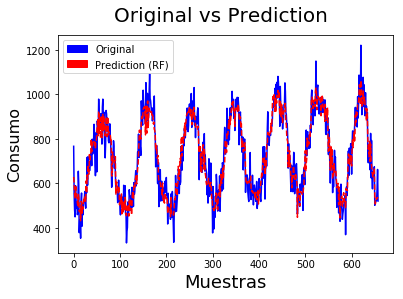

In [59]:
plt.plot(order_labels,'b-',rfOrder_predictions,'r--')
plt.suptitle('Original vs Prediction', fontsize=20)
plt.xlabel('Muestras', fontsize=18)
plt.ylabel('Consumo', fontsize=16)
blue_patch = mpatches.Patch(color='blue', label='Original')
red_patch = mpatches.Patch(color='red', label='Prediction (RF)')
plt.legend(handles=[blue_patch,red_patch])

Como se puede observar, el modelo logra ajustarse bastante bien a la curva original sin sobreajustarse a los valores extremos.

### 3.2.- Support Vector Regression
<a id="svr"></a>

In [62]:
from sklearn.svm import SVR

Como SVR utiliza varios hyper-parámetros para ajsutar el modelo, se utiliza el método de Grid Search para buscar los que produzcan los mejores resultados posibles que consiste básicamente en probar una tupla finita de posibles
valores, luego si es necesario explorar ciertas áreas de menor error con valores en ese rango. Se entrena el SVR, utilizando un kernel radial.
También cabe destacar que se utiliza 10-fold cross validation para la validación del modelo.
Los parámetros a ajustar corresponden a costo, epsilon y gamma y dependiendo de los valores utilizado influirán en cuanto se ajusta el modelo a los datos.
El costo corresponde a una penalización que se le otorga a los puntos de las muestras no separables que se encuentran  en el lado incorrecto del plano, el epsilon define un margen de tolerancia a la penalización alrededor de los vectores de soporte y gamma es un parámetro del kernel radial que regula el radio de área de influencia de los vectores de soporte.

In [63]:
param_grid = {
    'C': [0.25,0.5,1,2,4,8,16,32,64,128,256,512],
    'epsilon': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    'gamma': [0.625,0.25,0.5,1,2,4,8]
}

In [64]:
svr = SVR()
svrModel = GridSearchCV(estimator = svr, param_grid = param_grid, cv = 10)

In [65]:
svrModel.fit(train_features, train_labels)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'C': [0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512], 'gamma': [0.625, 0.25, 0.5, 1, 2, 4, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [66]:
svrModel.best_params_

{'C': 512, 'epsilon': 1, 'gamma': 4}

Se realiza la predicción con los mejores parámetros

In [67]:
svrModel = SVR(C=512, epsilon=1, gamma=4)

In [68]:
svrModel.fit(train_features, train_labels)

SVR(C=512, cache_size=200, coef0=0.0, degree=3, epsilon=1, gamma=4,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [70]:
svrPredictions = svrModel.predict(test_features)

In [71]:
errors = abs(predictions - test_labels)

In [72]:
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

('Mean Absolute Error:', 57.31, 'degrees.')


El error obtenido es un poco mayor al de Random Forest

Al igual que en el modelo anterior, se ordenan las predicciones para ver como se ajusta a la curva del conjunto de pruebas

In [147]:
svrOrder_predictions = pd.DataFrame(predictions)
svrOrder_predictions = svrOrder_predictions.loc[order_features.index.values]
svrOrder_predictions.head()

0
629  640.712507
544  623.987411
433  538.374309
337  524.254724
7    592.575561

In [148]:
svrOrder_predictions = svrOrder_predictions.reset_index(drop=True)
svrOrder_predictions.head()

0
0  640.712507
1  623.987411
2  538.374309
3  524.254724
4  592.575561

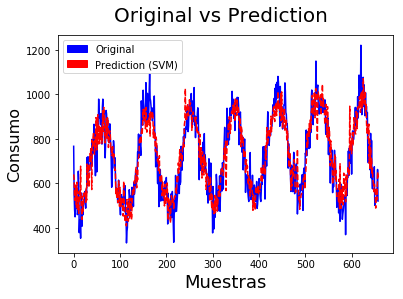

In [97]:
plt.plot(order_labels,'b-',svrOrder_predictions,'r--')
plt.suptitle('Original vs Prediction', fontsize=20)
plt.xlabel('Muestras', fontsize=18)
plt.ylabel('Consumo', fontsize=16)
blue_patch = mpatches.Patch(color='blue', label='Original')
red_patch = mpatches.Patch(color='red', label='Prediction (SVM)')
plt.legend(handles=[blue_patch,red_patch])

Si bien el modelo tiene un poco más de error que el anterior, también se ajusta muy bien a la curva original

### 3.3.- Decision trees
<a id="dl"></a>

In [78]:
from sklearn import tree

In [79]:
dtModel = tree.DecisionTreeClassifier(criterion='gini') 

Este modelo es mucho más sencillo que los anteriores y se utiliza como un punto de comparación. No requiere mayores ajustes en los parámetros por lo que su entrenamiento es bastante rápido.

In [80]:
dtModel.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [83]:
dtPredictions= dtModel.predict(test_features)

In [86]:
errors = abs(dtPredictions - test_labels)

In [87]:
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

('Mean Absolute Error:', 66.16, 'degrees.')


Como era de esperarse resulta el modelo con mayor error.

In [180]:
dtOrder_predictions = pd.DataFrame(dtPredictions)
dtOrder_predictions = dtOrder_predictions.loc[order_features.index.values]
dtOrder_predictions.head()

0
629  653
544  535
433  470
337  552
7    610

In [181]:
dtOrder_predictions = dtOrder_predictions.reset_index(drop=True)
dtOrder_predictions.head()

0
0  653
1  535
2  470
3  552
4  610

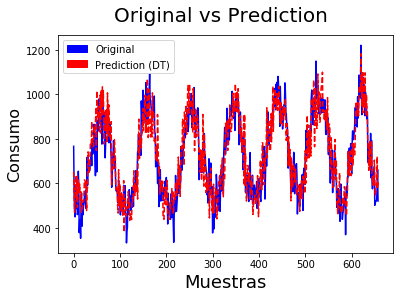

In [182]:
plt.plot(order_labels,'b-',dtOrder_predictions,'r--')
plt.suptitle('Original vs Prediction', fontsize=20)
plt.xlabel('Muestras', fontsize=18)
plt.ylabel('Consumo', fontsize=16)
blue_patch = mpatches.Patch(color='blue', label='Original')
red_patch = mpatches.Patch(color='red', label='Prediction (DT)')
plt.legend(handles=[blue_patch,red_patch])

Si bien muchas lineas escapan de la curva original, aún es visible que la forma de las predicciones se asemejan a esta.

## 4.- Análisis y evaluación de los modelos
<a id="anal"></a>

Los errores obtenidos en regresión no son tan fáciles de interpretar como los de clasificación y por lo general el criterio de selección se realiza a través de una serie de métricas. Las más importantes para evaluar modelos de regresión son las siguientes:

MSE (Mean Squared Error): es el promedio de la diferencia entre los valores originales y los de la predicción.

MAE (Mean Absolute Error): es el promedio de la diferencia en valor absoluto entre el conjunto otriginal y la predicción.

R^2 score: Mide la calidad del modelo para replicar resultados y la proporción de variación de los resultados que puede explicarse por el modelo

RMSE (Root Mean Squared Error): Es una medida de qué tan dispersos o concentrados están los residuos de la línea original o de ajuste

A continuación se define una función para calcular todas estas medidas y evaluar los modelos.

In [141]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2

In [183]:
def calculateErrors(rfPredictions, svrPredictions,dtPredictions, testSet):
    print("\t  RF \t\t-\t\t SVR \t-\t\t DT\n")
    #MSE
    print("MSE:\t %f \t-\t %f \t-\t %f" % (mse(rfPredictions, testSet),mse(svrPredictions, testSet),mse(dtPredictions, testSet)))
    #MAE
    print("MAE:\t %f \t-\t %f \t-\t %f" % (mae(rfPredictions, testSet),mae(svrPredictions, testSet),mae(dtPredictions, testSet)))
    #R2
    print("MSE:\t %f \t-\t %f \t-\t %f" % (r2(rfPredictions, testSet),r2(svrPredictions, testSet),r2(dtPredictions, testSet)))

In [184]:
calculateErrors(rfOrder_predictions,svrOrder_predictions,dtOrder_predictions,order_labels)

	  RF 		-		 SVR 	-		 DT

MSE:	 2823.001301 	-	 5352.568422 	-	 7130.165653
MAE:	 42.887347 	-	 57.310739 	-	 66.162614
MSE:	 0.896156 	-	 0.788487 	-	 0.762244


En los errores presentados se puede notar que en general el modelo de Random Forest fue el que obtuvo las mejores predicciones y Decision Trees las peores. El caso de estudiar varios errores es debido a que en ocasiones los valores son tan cercanos que se necesita otra medida, por ejemplo si el MAE es igual, el MSE indica cual posee mayor dispersión, o la calidad con el estimador R^2 (cuyo valor máximo es 1). En este caso los errores resultan claramente diferenciables.